### 0. GETTING STARTED

In [1]:
!pip install rdkit

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
import base64
import matplotlib.pyplot as plt
from io import BytesIO
%matplotlib inline
df = pd.read_csv('datapreprocess.csv')
PandasTools.AddMoleculeColumnToFrame(df, 'SMILES', 'Molecule')

import pandas as pd
import numpy as np
import seaborn as sn
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def generate_fpts(data):
    Mfpts = []
    for mol in tqdm(data):
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=256)
        Mfpts.append(mfpt)

    return np.array(Mfpts)
mfpts = generate_fpts(df.Molecule)

100%|██████████| 1691/1691 [00:00<00:00, 2434.23it/s]


In [3]:
morgan = pd.DataFrame(mfpts)
morgan

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,1,0,1,0,0,1
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,1
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1687,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1688,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1689,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


In [4]:
IC = pd.DataFrame(df['pIC50'], columns=['pIC50'])
IC

,pIC50
0,6.924453
1,6.732828
2,6.359519
3,6.392545
4,6.681937
...,...
1686,7.124939
1687,6.632644
1688,7.645892
1689,6.327902


### 1. FIRST EVALUATION (RAW DATABASE)

#### 1.1. FIRST CV

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

X = morgan
y = IC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

param_grid = {
    'C': [0.01,0.1,1,5,10],
    'epsilon': [0.01,0.05, 0.1,0.5,1],
    'kernel': ['rbf','poly','linear']
}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, scoring='r2', cv = 3, verbose = 2)

grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

y_pred_test = best_svr.predict(X_test)
y_pred_train = best_svr.predict(X_train)

print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=0.01, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ................C=0.01, epsilon=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, epsilon=0.05, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.05, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.01, epsilon=0.0

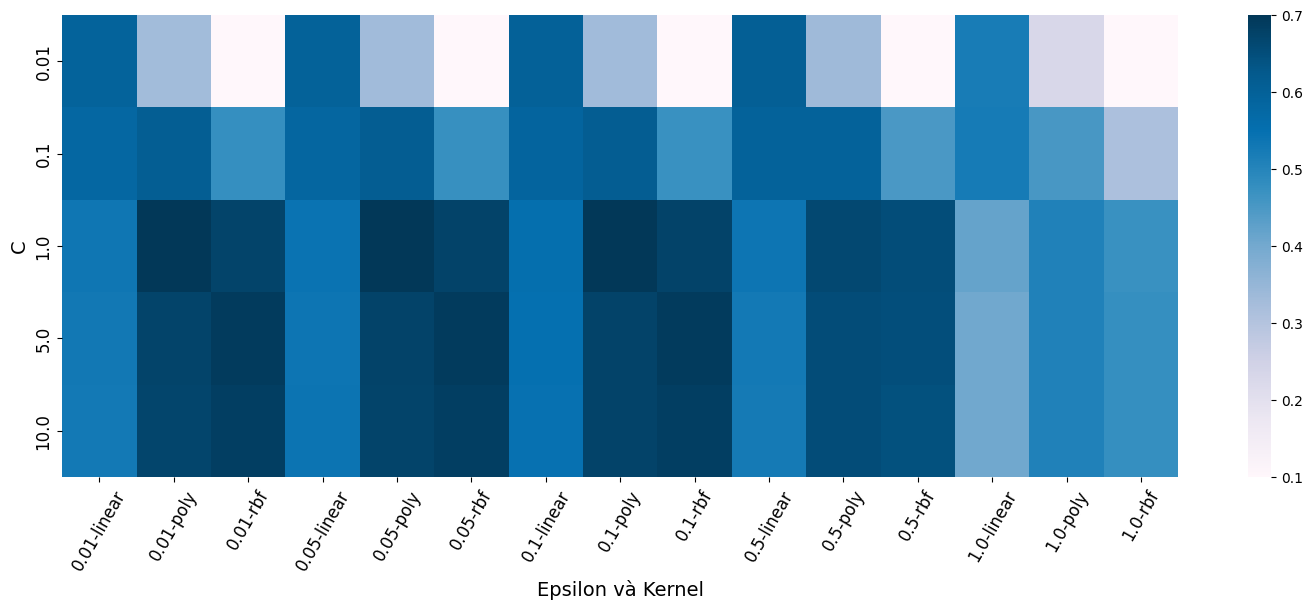

In [249]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the grid search results
results = grid_search.cv_results_

# Extract the parameters and scores
param_C = results['param_C'].data
param_epsilon = results['param_epsilon'].data
param_kernel = results['param_kernel'].data
mean_test_score = results['mean_test_score']

# Create a dataframe from the data
data = pd.DataFrame({'C': param_C, 'epsilon': param_epsilon, 'kernel': param_kernel, 'score': mean_test_score})

# Pivot the dataframe to create a matrix for the heatmap
matrix = data.pivot_table(index='C', columns=['epsilon', 'kernel'], values='score')

# Create the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(matrix, cmap='PuBu', cbar=True, fmt='.10f', vmin = 0.1, vmax = 0.7)

# Set labels and title
plt.xlabel('Epsilon và Kernel', fontsize = 14)
plt.ylabel('C', fontsize = 14)
plt.xticks(rotation=60, fontsize = 12)
plt.yticks( fontsize = 12)
# plt.title('Kết Grid Search')

# Display the plot
plt.show()

#### 1.2. SECOND CV

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

X = morgan
y = IC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

param_grid1 = {
    'C': [1,2,3,4,5,6,7,8,9,10],
    'epsilon': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
    'kernel': ['poly','rbf']
}

svr = SVR()

grid_search1 = GridSearchCV(svr, param_grid1, scoring='r2', cv = 3, verbose = 2)

grid_search1.fit(X_train, y_train)

best_svr1 = grid_search1.best_estimator_

y_pred_test = best_svr1.predict(X_test)
y_pred_train = best_svr1.predict(X_train)

print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))
print("Best parameters:", grid_search1.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.1s
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END .....................C=1, epsilon=0.02, kernel=poly; total time=   0.0s
[CV] END ......................C=1, epsilon=0.02, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.02, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, epsilon=0.

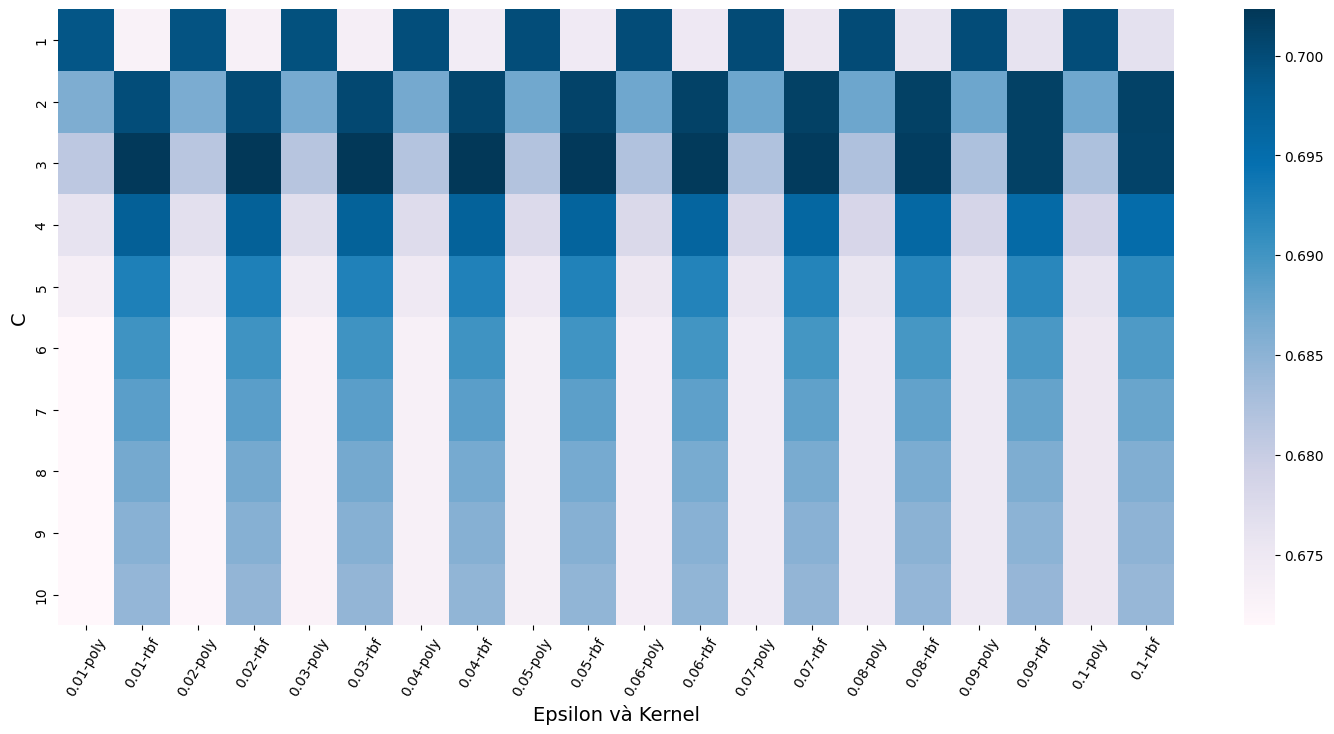

In [253]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get the grid search results
results = grid_search1.cv_results_

# Extract the parameters and scores
param_C = results['param_C'].data
param_epsilon = results['param_epsilon'].data
param_kernel = results['param_kernel'].data
mean_test_score = results['mean_test_score']

# Create a dataframe from the data
data = pd.DataFrame({'C': param_C, 'epsilon': param_epsilon, 'kernel': param_kernel, 'score': mean_test_score})

# Pivot the dataframe to create a matrix for the heatmap
matrix = data.pivot_table(index='C', columns=['epsilon', 'kernel'], values='score')

# Create the heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(matrix, cmap='PuBu', cbar=True, fmt='.8f')

# Set labels and title
plt.xlabel('Epsilon và Kernel', fontsize = 14)
plt.ylabel('C', fontsize = 14)
plt.xticks(rotation=60)
# plt.title('Kết Grid Search')

# Display the plot
plt.show()

#### 1.3. RANDOMIZED SEARCH

In [255]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, expon
import numpy as np
from sklearn.svm import SVR

baseline_svm = SVR()
model_params = {
    'C': uniform(loc=3, scale=1),
    'kernel': [ 'rbf'],
    'epsilon': uniform(loc=0.01, scale=0.1)
}
randomized_search = RandomizedSearchCV(estimator=baseline_svm, param_distributions=model_params, n_iter=100 , verbose = 2,
                                    cv=3)

randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END C=3.639306789656641, epsilon=0.03855526457673199, kernel=rbf; total time=   0.1s
[CV] END C=3.639306789656641, epsilon=0.03855526457673199, kernel=rbf; total time=   0.1s
[CV] END C=3.639306789656641, epsilon=0.03855526457673199, kernel=rbf; total time=   0.1s
[CV] END C=3.2560480589049936, epsilon=0.028293361896529257, kernel=rbf; total time=   0.1s
[CV] END C=3.2560480589049936, epsilon=0.028293361896529257, kernel=rbf; total time=   0.1s
[CV] END C=3.2560480589049936, epsilon=0.028293361896529257, kernel=rbf; total time=   0.1s
[CV] END C=3.858554666549503, epsilon=0.024981696916066057, kernel=rbf; total time=   0.1s
[CV] END C=3.858554666549503, epsilon=0.024981696916066057, kernel=rbf; total time=   0.1s
[CV] END C=3.858554666549503, epsilon=0.024981696916066057, kernel=rbf; total time=   0.1s
[CV] END C=3.2487794976831728, epsilon=0.02523239072162037, kernel=rbf; total time=   0.1s
[CV] END C=3.24877949768317

RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023A039ACAD0>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023A02E80750>,
                                        'kernel': ['rbf']},
                   verbose=2)

In [256]:
print("Random Score:", randomized_search.best_params_)
print("Random Score:", randomized_search.best_score_)

Random Score: {'C': 3.0335571516972455, 'epsilon': 0.02478760995246643, 'kernel': 'rbf'}
Random Score: 0.7022084294357008


#### 1.4. FIRST EVALUATION

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

X = morgan
y = IC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

param_grid1 = {
    'C': [3.0335571516972455],
    'epsilon': [0.02478760995246643],
    'kernel': ['rbf']
}

svr = SVR()

grid_search1 = GridSearchCV(svr, param_grid1, scoring='r2', cv = 10, verbose = 2)

grid_search1.fit(X_train, y_train)

best_svr1 = grid_search1.best_estimator_

y_pred_test = best_svr1.predict(X_test)
y_pred_train = best_svr1.predict(X_train)

print("R-squared on test set:", r2_score(y_test, y_pred_test))
print("R-squared on train set:", r2_score(y_train, y_pred_train))
print("Best parameters:", grid_search1.best_params_)
print(grid_search1.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.2s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.1s
R-squared on test set: 0.7603

### 2. OUTLIERS DETECTION 

In [111]:
leverage_train = np.diag(X_train@ np.linalg.pinv(X_train.T @ X_train) @ X_train.T)

In [ ]:
y_train['pred'] = y_pred_train
y_train['residual'] = y_train['pIC50'] - y_train['pred']
y_train['squared'] = y_train['residual']**2
mse_train = y_train['squared'].sum()/(len(y_train['squared']))
y_train['leverage'] = leverage_train
y_train['standard'] = y_train['residual']/(mse_train)**0.5

In [ ]:
elements = []
elements1 = []

for i, element in enumerate(y_train['leverage']):
    if element > 0.570266 or element < 0:
        elements.append(element)

for j, element1 in enumerate(y_train['standard']):
    if element1 >= 3 or element1 <= -3 :
        elements1.append(element1)

a = y_train[y_train.leverage.isin(elements)]
b = y_train[y_train.standard.isin(elements1)]

c = pd.concat([a,b], axis = 0)
c = c.drop_duplicates()
c.index

In [5]:
index_train = [518,
35,
685,
408,
1089,
510,
22,
693,
343,
1687,
219,
783,
649,
857,
589,
238,
608,
48,
362,
531,
728,
679,
795,
1594,
369,
627,
933,
629,
421,
555,
771,
1276,
802,
1126,
595,
12,
1090,
764,
548,
218,
370,
1267,
823,
131,
1311,
570,
835,
1533,
100,
1375,
820,
502,
1066,
886,
1243,
517,
1541,
722,
997,
331,
186,
409,
425,
527,
1429,
1448,
640,
732,
415,
111,
735,
1532,
1024,
521,
1353,
1106,
298,
1647,
49,
488,
1476,
907,
471,
6,
1339,
212,
714,
1011,
1244,
705,
516,
120,
1461,
1327,
1494,
1187,
965,
1154,
1667,
313,
1265,
580,
309,
745,
1683,
358,
508,
198,
442,
632,
803,
875,
1074,
1196,
1430,
1100,
1583,
1669,
1205,
47,
1218,
1523,
797,
1139,
865,
756,
847,
147,
614,
106,
616,
46,
108,
499,
143,
1246,
449,
1156,
1012,
579,
672,
156,
357,
1414,
1256,
924,
1524,
233,
1050,
1095,
1557,
504,
1239,
1122,
173,
336,
539,
543,
146,
776,
726,
1404,
1141,
440,
1590,
380,
1469,
411,
215,
1326,
192,
1268,
1200,
1609,
590,
1297,
839,
1191,
395,
1500,
581,
262,
1361,
37,
429,
1300,
1233,
838,
140,
655,
851,
345,
1282,
251,
1038,
563,
205,
644,
1634,
501,
1085,
562,
1456,
801,
410,
888,
1605,
1096,
706,
21,
178,
133,
782,
630,
1042,
913,
398,
1336,
1234,
387,
93,
392,
142,
187,
208,
1445,
397,
624,
1552,
748,
990,
1460,
814,
1296,
361,
68,
1301,
1406,
424,
806,
845,
267,
1581,
1228,
1415,
1373,
330,
278,
926,
812,
697,
1070,
375,
1632,
284,
1394,
1413,
772,
729,
769,
1371,
929,
1028,
852,
1229,
603,
1645,
1555,
327,
1502,
237,
1499,
363,
1603,
650,
234,
141,
648,
269,
1649,
1162,
937,
195,
1013,
1117,
1462,
1662,
1257,
794,
294,
1014,
1658,
691,
301,
461,
698,
1626,
701,
299,
107,
1600,
1053,
1030,
889,
51,
228,
1592,
1212,
681,
793,
659,
1576,
1531,
971,
1392,
1069,
1688,
1280,
1332,
443,
52,
256,
751,
1561,
1279,
647,
786,
1202,
1288,
557,
689,
637,
544,
300,
1306,
1044,
628,
882,
1231,
1146,
185,
1388,
1266,
758,
32,
1530,
514,
684,
1614,
41,
1086,
651,
943,
202,
591,
1425,
804,
207,
877,
1359,
161,
642,
987,
1252,
18,
1025,
568,
670,
988,
1075,
1426,
1023,
1103,
189,
273,
1298,
1155,
2,
836,
1642,
130,
112,
1690,
917,
439,
1145,
433,
447,
610,
574,
1457,
850,
721,
279,
96,
773,
1198,
993,
382,
226,
1333,
64,
1487,
320,
859,
287,
457,
1566,
177,
1376,
484,
1405,
1650,
1639,
1334,
1577,
1681,
1091,
861,
26,
1522,
638,
785,
497,
918,
635,
1527,
713,
538,
957,
417,
1635,
1071,
910,
1183,
546,
275,
1556,
203,
1133,
1098,
1464,
1188,
1466,
1529,
938,
573,
479,
9,
487,
1147,
221,
152,
306,
1420,
540,
403,
564,
75,
1181,
1137,
1123,
1214,
1325,
144,
575,
1132,
777,
1585,
1078,
631,
1161,
456,
1345,
376,
901,
312,
1486,
1209,
526,
1320,
547,
266,
1315,
427,
366,
946,
244,
1673,
879,
56,
639,
730,
712,
936,
1215,
285,
1482,
184,
125,
963,
853,
7,
1111,
463,
942,
788,
1396,
1410,
496,
1374,
951,
666,
1151,
844,
1035,
753,
860,
452,
1348,
1160,
325,
545,
259,
20,
755,
124,
676,
866,
127,
717,
1510,
551,
290,
264,
1492,
1261,
654,
458,
1682,
1399,
293,
1080,
1672,
289,
349,
1046,
973,
1615,
817,
1568,
1073,
881,
385,
969,
423,
54,
1477,
29,
1262,
585,
831,
277,
1459,
530,
626,
1444,
258,
914,
966,
8,
83,
925,
69,
1295,
588,
609,
437,
1536,
1167,
104,
420,
493,
599,
577,
265,
169,
16,
241,
406,
669,
1079,
695,
1619,
586,
1628,
1378,
44,
657,
42,
1385,
342,
1528,
1006,
1227,
606,
483,
1309,
955,
819,
1516,
964,
28,
1186,
542,
1644,
1496,
232,
1034,
1360,
1540,
1259,
1545,
1208,
1622,
746,
346,
381,
355,
710,
1599,
1040,
731,
707,
1513,
1350,
532,
444,
752,
1245,
840,
1567,
741,
1286,
1481,
529,
792,
558,
1116,
1219,
136,
1018,
1175,
373,
229,
583,
225,
405,
727,
85,
1663,
876,
1149,
1052,
1587,
450,
257,
607,
1463,
45,
1130,
921,
940,
567,
734,
1447,
958,
1593,
509,
1335,
829,
1665,
1539,
477,
799,
1118,
1389,
1512,
1677,
1107,
1240,
86,
222,
288,
1390,
475,
1652,
1553,
1565,
1124,
976,
920,
1088,
1408,
1621,
554,
641,
135,
413,
324,
986,
1387,
1172,
1473,
618,
155,
869,
959,
371,
166,
1238,
908,
15,
1661,
1273,
1163,
736,
896,
1402,
593,
700,
1564,
337,
1000,
506,
718,
1189,
981,
1504,
1643,
94,
30,
842,
1099,
1087,
1003,
70,
1210,
668,
1417,
1152,
399,
656,
92,
350,
724,
613,
454,
968,
1442,
1520,
365,
1041,
1058,
1432,
227,
394,
249,
1362,
723,
1440,
464,
1443,
1171,
1248,
948,
1138,
1595,
779,
388,
90,
396,
55,
912,
674,
1354,
849,
1064,
1659,
431,
780,
1054,
253,
1543,
95,
1610,
690,
975,
1488,
1249,
634,
1004,
1631,
1174,
904,
1474,
1185,
1026,
1544,
992,
738,
1511,
113,
1654,
1285,
999,
451,
556,
99,
1478,
1293,
528,
1611,
870,
1275,
841,
478,
897,
1221,
725,
223,
316,
826,
1453,
671,
821,
1093,
995,
1222,
596,
1467,
445,
1558,
359,
939,
636,
716,
1263,
597,
1471,
1048,
1159,
873,
305,
565,
871,
1140,
1176,
448,
767,
1253,
1115,
1446,
353,
119,
825,
1519,
1291,
412,
1323,
1419,
584,
128,
1679,
1625,
536,
872,
188,
71,
204,
1602,
1393,
1617,
3,
1640,
561,
553,
1065,
1412,
1646,
38,
170,
617,
24,
1518,
1216,
1051,
1217,
53,
472,
377,
1247,
694,
1281,
1352,
953,
1666,
1237,
216,
1381,
970,
1305,
1010,
1142,
283,
65,
145,
367,
1498,
1606,
1579,
50,
808,
952,
1213,
1582,
1274,
391,
210,
833,
902,
1225,
974,
416,
200,
1113,
1437,
883,
980,
1269,
1479,
260,
1397,
1045,
1465,
982,
132,
1517,
1049,
1105,
1366,
1134,
905,
515,
867,
805,
1451,
486,
295,
462,
592,
1,
255,
165,
1165,
915,
1337,
1651,
1304,
891,
1061,
1612,
263,
1173,
620,
1250,
661,
418,
1347,
150,
1039,
522,
1192,
1029,
31,
468,
386,
744,
954,
245,
1549,
1423,
1180,
432,
268,
550,
1484,
1538,
1330,
1102,
784,
1179,
270,
404,
1114,
587,
927,
303,
611,
893,
761,
1434,
1501,
878,
615,
14,
1470,
1194,
1255,
326,
1449,
511,
214,
302,
737,
334,
11,
766,
1596,
469,
291,
956,
311,
231,
537,
1570,
680,
230,
315,
34,
57,
1506,
868,
243,
1418,
1489,
491,
711,
1016,
1199,
703,
747,
282,
0,
84,
828,
763,
1554,
646,
1493,
459,
10,
625,
796,
822,
660,
1686,
1563,
1675,
1242,
328,
1284,
1569,
1119,
126,
699,
77,
129,
436,
193,
884,
500,
1616,
73,
1403,
434,
117,
17,
1452,
1037,
1063,
378,
13,
1021,
1618,
967,
1059,
931,
633,
1356,
535,
384,
1148,
621,
898,
360,
175,
344,
675,
932,
27,
314,
453,
1344,
1630,
1157,
248,
916,
1201,
211,
1573,
1104,
1542,
1458,
1551,
507,
824,
1537,
1480,
1377,
1204,
1036,
512,
118,
1441,
1211,
1168,
1559,
890,
1391,
815,
960,
176,
5,
1077,
1624,
1657,
619,
236,
523,
435,
1055,
1623,
807,
1358,
292,
1170,
1507,
1076,
332,
1302,
978,
1047,
922,
103,
1303,
892,
594,
818,
286,
1129,
749,
182,
33,
505,
348,
393,
297,
199,
742,
333,
476,
80,
401,
1535,
213,
1197,
1131,
1562,
1019,
692,
402,
323,
739,
180,
379,
569,
151,
495,
281,
235,
338,
903,
1580,
652,
217,
149,
1226,
1641,
1575,
687,
572,
66,
460,
490,
1604,
1270,
224,
911,
1032,
389,
809,
930,
190,
1324,
246,
846,
874,
319,
1251,
1668,
1664,
250,
612,
743,
1648,
534,
549,
465,
1022,
813,
1097,
1678,
1534,
677,
645,
989,
1424,
961,
854,
492,
171,
686,
1547,
123,
663,
1060,
1588,
762,
1409,
1491,
122,
154,
1368,
1365,
1258,
827,
643,
1158,
1571,
23,
1342,
467,
1515,
664,
109,
81,
482,
179,
720,
72,
811,
768,
1108,
1292,
702,
1636,
665,
909,
1472,
781,
1633,
667,
1166,
1190,
422,
1382,
559,
390,
1598,
895,
1321,
352,
254,
1505,
1112,
1121,
60,
276,
1206,
76,
304,
1150,
1629,
340,
322,
1169,
1082,
1308,
101,
163,
1182,
407,
1613,
1436,
578,
158,
1431,
1497,
1092,
1062,
1027,
1015,
800,
1638,
1110,
148,
708,
43,
1656,
1548,
78,
115,
1428,
116,
541,
696,
310,
105,
40,
470,
709]
indice_train1 = [380,  378,  379, 1187, 1012, 1200, 1191, 1605, 1070, 1688, 1280, 1025,
       1487, 1147, 1111, 1568,  914, 1644, 1545, 1663,   86, 1390,  227, 1443,
       1174, 1474, 1093, 1640, 1518, 1305, 1029, 1194,  302,  334, 1570, 1686,
        434, 1059, 1104, 1641, 1664, 1588, 1092]
index_train_new1 = [x for x in index_train if x not in indice_train1]
len(index_train_new1)

1309

In [6]:
index_test = [848,
945,
984,
1379,
351,
473,
1383,
600,
1331,
280,
341,
1125,
503,
1674,
832,
1278,
36,
1005,
1357,
261,
1589,
1033,
1193,
979,
1689,
110,
983,
810,
1084,
1343,
1608,
455,
962,
19,
719,
1680,
372,
1671,
1550,
1427,
1490,
1136,
1407,
1081,
1398,
318,
944,
62,
843,
1289,
1299,
317,
830,
481,
885,
1177,
159,
1521,
623,
138,
174,
1057,
383,
67,
1128,
194,
1574,
1223,
1264,
252,
59,
61,
1341,
513,
1067,
1031,
1370,
480,
97,
167,
181,
489,
368,
1421,
1684,
1002,
1307,
335,
682,
1043,
58,
474,
935,
164,
864,
494,
1236,
426,
533,
74,
1586,
604,
757,
1572,
1384,
114,
949,
560,
1235,
856,
1313,
899,
247,
900,
1072,
1340,
653,
774,
1143,
1372,
658,
1322,
1272,
1416,
1314,
928,
1101,
715,
519,
39,
923,
1017,
89,
347,
1435,
1329,
1207,
862,
994,
157,
1294,
571,
82,
1127,
1637,
950,
87,
296,
1395,
1627,
1056,
98,
789,
1319,
1007,
1509,
172,
1450,
1009,
1676,
1591,
1260,
1475,
754,
168,
1386,
430,
816,
220,
1601,
1349,
1203,
1310,
919,
1578,
525,
1411,
1483,
704,
400,
520,
790,
1195,
1653,
1144,
206,
414,
191,
1422,
1485,
91,
733,
765,
880,
566,
274,
1020,
1290,
1495,
998,
1454,
775,
1254,
605,
239,
1400,
683,
894,
887,
137,
209,
1184,
1241,
1455,
1094,
1153,
196,
1328,
1526,
1660,
1230,
947,
321,
419,
1401,
374,
770,
858,
1584,
428,
582,
271,
197,
1503,
1001,
1597,
787,
1317,
240,
991,
601,
25,
622,
79,
1109,
242,
1468,
688,
102,
1655,
972,
308,
834,
466,
1120,
1685,
1380,
201,
1433,
1338,
1438,
1560,
778,
1232,
837,
855,
441,
121,
1367,
1620,
63,
1008,
1363,
339,
1670,
153,
1439,
1287,
863,
1135,
934,
1068,
364,
162,
1277,
759,
1351,
598,
1514,
134,
941,
1607,
985,
977,
354,
1525,
662,
798,
996,
906,
356,
750,
1346,
485,
160,
498,
552,
1546,
88,
760,
1164,
307,
438,
1508,
740,
272,
673,
576,
1312,
602,
139,
1355,
1178,
329,
183,
1224,
1316,
1220,
1364,
446,
678,
4,
1369,
1318,
524,
1283,
1271,
791,
1083]
indice_test = [1586, 1101, 1127, 1495, 1655, 1178,1033,1357,1094,1450
]
index_test_new = [x for x in index_test if x not in indice_test]

### 3. SECOND EVALUATION (FINAL DATABASE)

#### 3.1. EVALUATION WITH FINAL DATABASE

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
import numpy as np


X = morgan
y = IC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

X_train_new= X_train.loc[X_train.index.isin(index_train_new1)]
y_train_new= y_train.loc[y_train.index.isin(index_train_new1)]


X_test_new = X_test.loc[X_test.index.isin(index_test_new)]
y_test_new = y_test.loc[y_test.index.isin(index_test_new)]

svr = SVR(C = 3.0335571516972455, epsilon = 0.02478760995246643, kernel='rbf')

svr.fit(X_train_new, y_train_new)
y_pred_test1= svr.predict(X_test_new)
y_pred_train = svr.predict(X_train_new)

print("R-squared on test set:", r2_score(y_test_new, y_pred_test1))
print("R-squared on train set:",r2_score(y_train_new, y_pred_train))

R-squared on test set: 0.8255549377969342
R-squared on train set: 0.9920768567348833


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

X = morgan
y = IC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

param_grid1 = {
    'C': [3.0335571516972455],
    'epsilon': [0.02478760995246643],
    'kernel': ['rbf']
}

X_train_new= X_train.loc[X_train.index.isin(index_train_new1)]
y_train_new= y_train.loc[y_train.index.isin(index_train_new1)]


X_test_new = X_test.loc[X_test.index.isin(index_test_new)]
y_test_new = y_test.loc[y_test.index.isin(index_test_new)]

svr = SVR()

grid_search1 = GridSearchCV(svr, param_grid1, scoring='r2', cv = 10, verbose = 2)

grid_search1.fit(X_train_new, y_train_new)

print(grid_search1.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.7s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.4s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.3s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.4s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.4s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.3s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.4s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.4s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.3s
[CV] END C=3.0335571516972455, epsilon=0.02478760995246643, kernel=rbf; total time=   0.5s
0.803630639548552


In [431]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test_new, y_pred_test1, squared=False)
rms

0.47924708771539665

In [432]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_new, y_pred_test1)
mae

0.3720451923149242

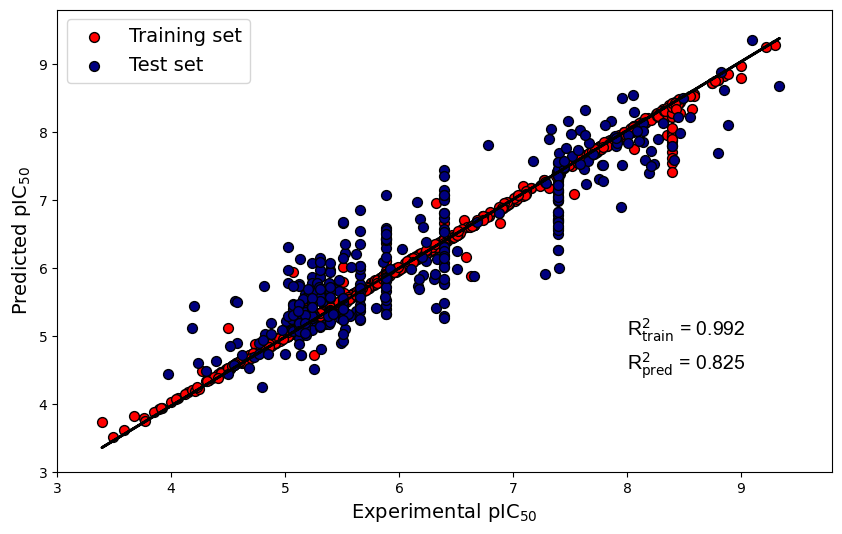

In [110]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = y_train_new['pIC50']
y_axis = y_train_new['pred']

x_axis1 = y_test_new['pIC50']
y_axis1 = y_test_new['pred']

x_combined = np.concatenate((x_axis, x_axis1))
y_combined = np.concatenate((y_axis, y_axis1))

plt.figure(figsize=(10, 6))

plt.scatter(x_axis, y_axis, color='red', label='Training set', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis1, y_axis1, color='navy', label='Test set', marker='o', s=50, edgecolors='black')

slope, intercept = np.polyfit(y_combined, x_combined, 1)
best_fit_line = slope * x_combined + intercept
plt.plot(x_combined, best_fit_line, color='black', linewidth=2.0)

plt.xlabel('Experimental pIC$_{50}$', fontsize=14)
plt.ylabel('Predicted pIC$_{50}$', fontsize=14)
plt.xlim(3, 9.8)  
plt.ylim(3, 9.8) 
plt.annotate('R$^2_{\mathrm{train}}$ = 0.992', xy=(8, 5), fontsize=14, fontname='Arial')
plt.annotate('R$^2_{\mathrm{pred}}$ = 0.825', xy=(8, 4.5), fontsize=14, fontname='Arial')
legend = plt.legend(loc='upper left', fontsize=14)

plt.show()

#### 3.2. TSNE

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity = 30.0, early_exaggeration=12.0, learning_rate=200, n_iter=1000,
            n_iter_without_progress=300,min_grad_norm=1e-07, metric='euclidean', random_state=78)
X_tsne = tsne.fit_transform(X)

tsne.kl_divergence_

0.606956958770752

In [73]:
X_tsnedf = pd.DataFrame(X_tsne)
X_tsnetrain, X_tsnetest, y_train, y_test = train_test_split(X_tsnedf, y, test_size=0.2, random_state=78)
X_tsne_train_train= X_tsnetrain.loc[X_tsnetrain.index.isin(index_train_new1)]
X_tsne_test_test= X_tsnetest.loc[X_tsnetest.index.isin(index_test_new)]

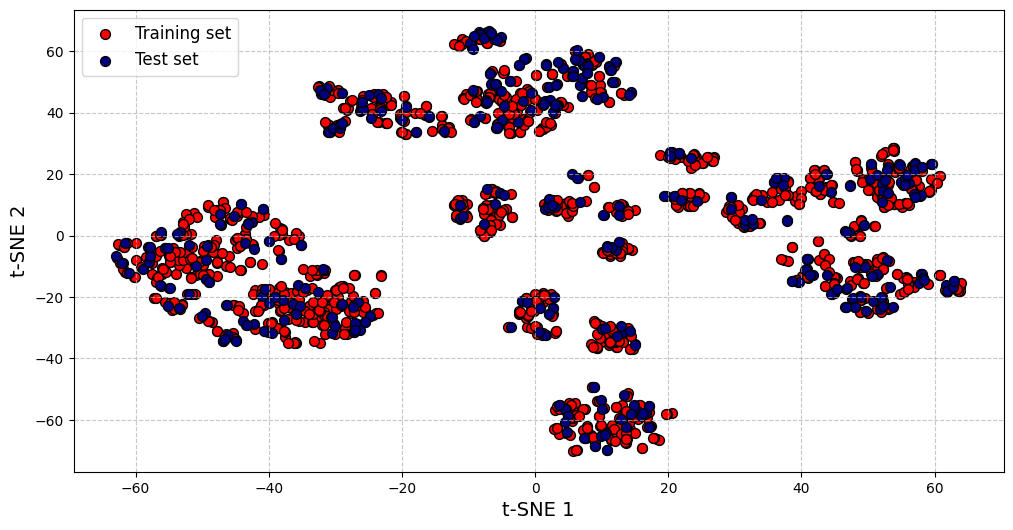

In [82]:
plt.figure(figsize=(12,6))
plt.scatter(X_tsne_train_train[0], X_tsne_train_train[1], color='red', label='Training set', marker='o', s=50, edgecolors='black')
plt.scatter(X_tsne_test_test[0], X_tsne_test_test[1], color= 'navy', label='Test set', marker='o', s=50,edgecolors='black')
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.grid(axis='x', linestyle='--', alpha=0.7, which='both')
# plt.title("t-SNE visualization")
plt.xlabel("t-SNE 1", fontsize = 14)
plt.ylabel("t-SNE 2", fontsize = 14)
legend = plt.legend( loc='upper left', fontsize=12)
plt.setp(legend.get_title(), fontsize=14, fontweight='bold')
plt.show()

In [407]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, perplexity=30.0, early_exaggeration=12.0, learning_rate=200,
            n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', random_state=78)
X_tsne = tsne.fit_transform(X)
X_tsnefull = pd.DataFrame(X_tsne)
t1, t2, t3, t4 = train_test_split(X_tsnefull, X_tsnefull, test_size=0.2, random_state=78)
t5 = np.array(t1)
t6 = np.array(t2)

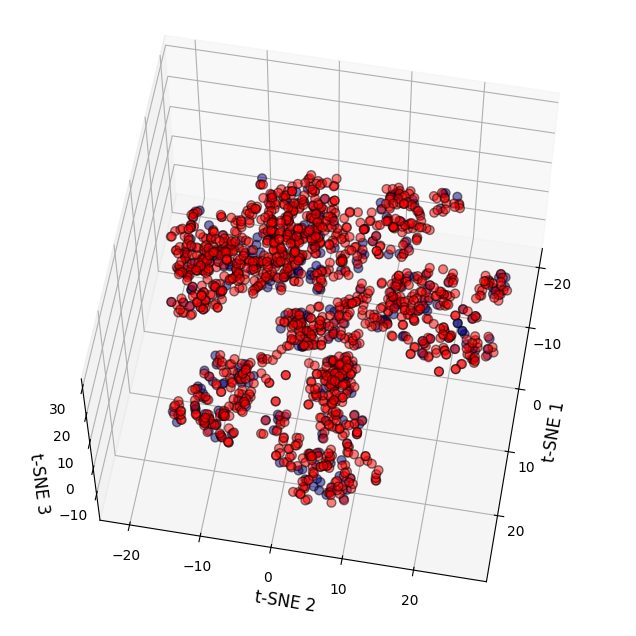

In [414]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t5[:, 0], t5[:, 1], t5[:, 2], c='red', marker='o', s=40, alpha=0.5, edgecolor = 'black', label='Tập huấn luyện')
ax.scatter(t6[:, 0], t6[:, 1], t6[:, 2], c='navy', marker='o', s=40, alpha=0.5, edgecolor = 'black', label='Tập kiểm tra')
ax.set_xlabel("t-SNE 1", fontsize=12)
ax.set_ylabel("t-SNE 2", fontsize=12)
ax.set_zlabel("t-SNE 3", fontsize=12)
# ax.legend(loc='upper right', fontsize=12)
ax.grid(True, linestyle='dashed', alpha=0.5)
ax.view_init(elev=60, azim= 10)

plt.show()

#### 3.3. APPLICABILITY DOMAIN

In [ ]:
leverage_test = np.diag(X_test_new@ np.linalg.pinv(X_train_new.T @ X_train_new) @ X_test_new.T)

In [112]:
y_test_new['pred'] = y_pred_test1
y_test_new['residual'] = y_test_new['pIC50'] - y_test_new['pred']
y_test_new['squared'] = y_test_new['residual']**2
mse_test = y_test_new['squared'].sum()/(len(y_test_new['squared']))
y_test_new['leverage'] = leverage_test
y_test_new['standard'] = y_test_new['residual']/(mse_test)**0.5

In [45]:
elements = []
elements1 = []

for i, element in enumerate(y_test_new['leverage']):
    if element > 0.570266 or element < 0:
        elements.append(element)

for j, element1 in enumerate(y_test_new['standard']):
    if element1 >= 3 or element1 <= -3 :
        elements1.append(element1)

a = y_test_new[y_test_new.leverage.isin(elements)]
b = y_test_new[y_test_new.standard.isin(elements1)]

c = pd.concat([a,b], axis = 0)
c = c.drop_duplicates()
c.shape

(0, 6)

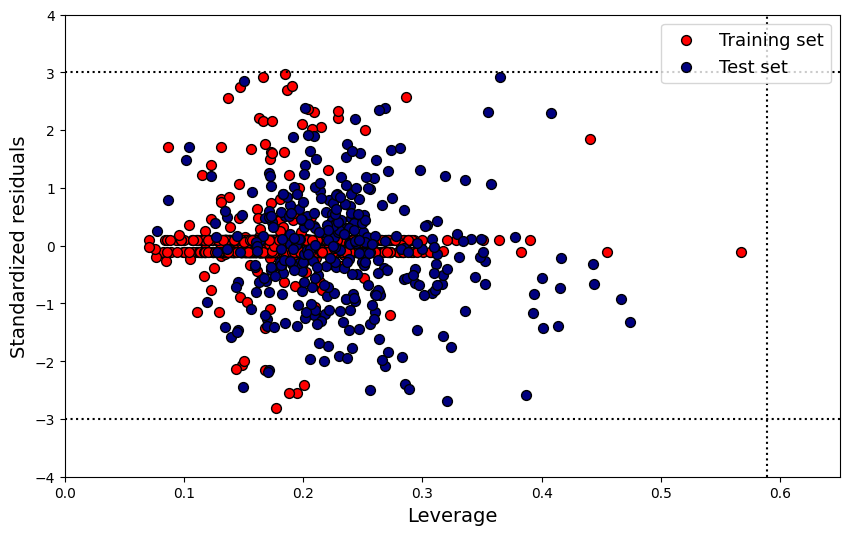

In [119]:
y_train_train = pd.read_csv('y_train_remove_outliers.csv')
x_axis = y_train_train['leverage']
y_axis = y_train_train['standard']
x_axis_1 = y_test_new['leverage']
y_axis_1 = y_test_new['standard']

plt.figure(figsize=(10, 6))

plt.scatter(x_axis, y_axis, color = 'red', label = 'Training set', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis_1, y_axis_1, color = 'navy', label = 'Test set', marker='o', s=50, edgecolors='black')


plt.xlabel('Leverage', fontsize = 14)
plt.ylabel('Standardized residuals', fontsize =14)
plt.xlim(0, 0.65)  
plt.ylim(-4, 4) 
plt.axhline(y = 3, color='black', linestyle='dotted')
plt.axhline(y = -3, color='black', linestyle='dotted')
plt.axvline(x =0.5889999, color='black', linestyle='dotted')
legend = plt.legend( loc='upper right', fontsize=13)
plt.show()

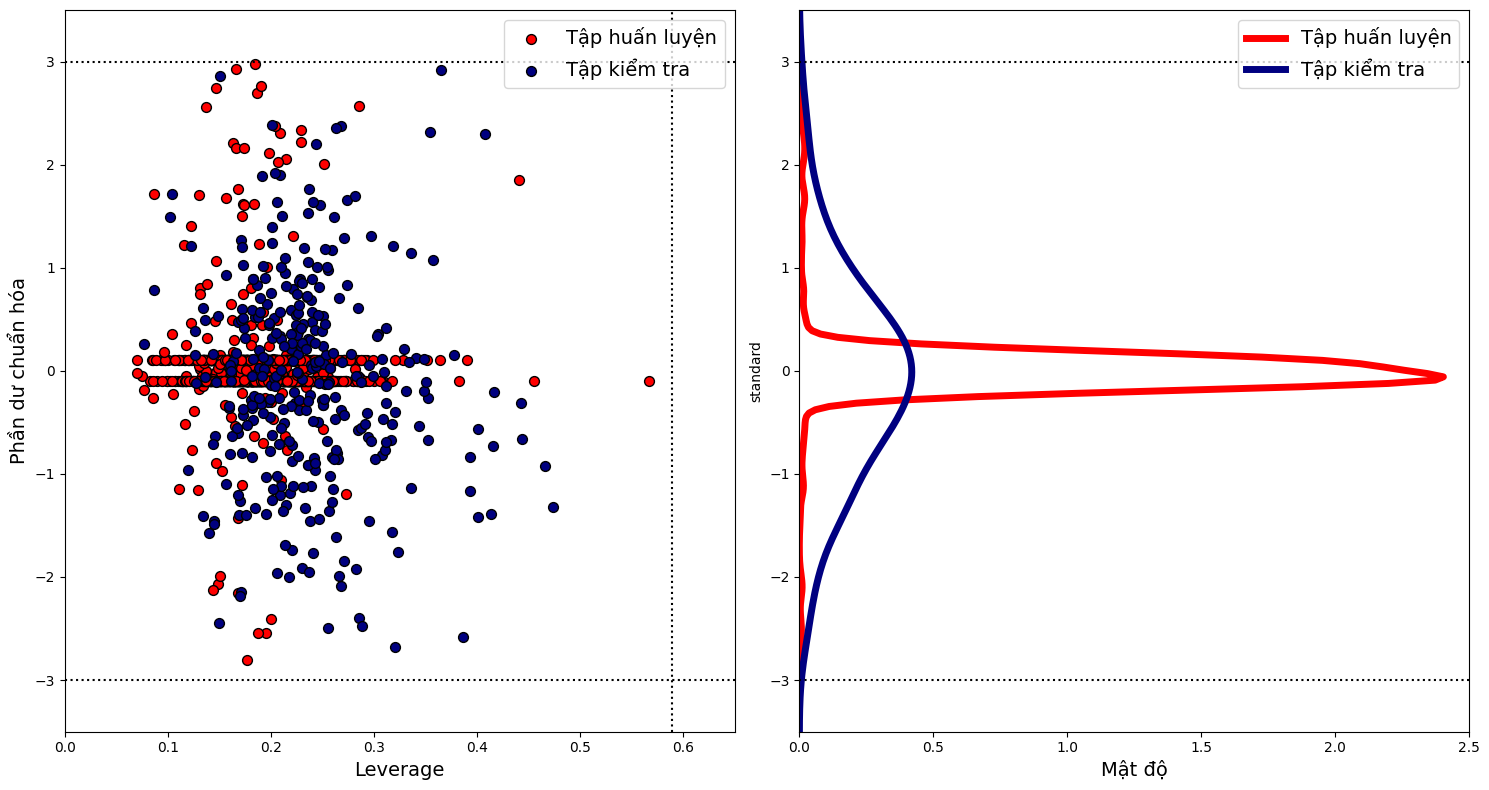

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

x_axis = y_train_train['leverage']
y_axis = y_train_train['standard']
x_axis_1 = y_test_new['leverage']
y_axis_1 = y_test_new['standard']

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.scatter(x_axis, y_axis, color='red', label='Tập huấn luyện', marker='o', s=50, edgecolors='black')
plt.scatter(x_axis_1, y_axis_1, color='navy', label='Tập kiểm tra', marker='o', s=50, edgecolors='black')
plt.xlabel('Leverage', fontsize=14)
plt.ylabel('Phần dư chuẩn hóa', fontsize=14)
plt.xlim(0, 0.65)
plt.ylim(-3.5, 3.5)
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.axvline(x =0.5889999, color='black', linestyle='dotted')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='upper right', fontsize=14)

plt.subplot(1, 2, 2)
sns.kdeplot(y_axis, color='red', linewidth=5, vertical=True, label='Tập huấn luyện')
sns.kdeplot(y_axis_1, color='navy', linewidth=5, vertical=True, label='Tập kiểm tra')
plt.xlabel('Mật độ', fontsize=14)
plt.ylim(-3.5,3.5)
plt.xlim(0, 2.5)
plt.axhline(y=3, color='black', linestyle='dotted')
plt.axhline(y=-3, color='black', linestyle='dotted')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc='upper right', fontsize=14)

plt.tight_layout()  
plt.show()

#### 3.4. Y-SCRAMBLE

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

def perform_y_scrambling_r2(model, X_train, X_val, Y_train, Y_val, num_iterations=10):
   original_score = model.fit(X_train, Y_train).score(X_val, Y_val)
   original_r2 = r2_score(Y_val, model.predict(X_val))
   print("Original Model Score:", original_score)
   print("Original R^2:", original_r2)

   scores = []

   for i in range(num_iterations):
      Y_train_scrambled = shuffle(Y_train)  # Shuffle the target variable
      model.fit(X_train, Y_train_scrambled)  # Retrain the model on scrambled data
      score = model.score(X_val, Y_val)
      scores.append(score)

   avg_score = np.mean(scores)

   print("Y Scrambling Average Score:", avg_score)

   print(scores)

In [348]:
perform_y_scrambling_r2(svr, X_train_new, X_train_new, y_train_new, y_train_new, num_iterations=100)

Original Model Score: 0.9920768567348833
Original R^2: 0.9920768567348833
Y Scrambling Average Score: -0.48702103433724026
[-0.5422730736513539, -0.5048670782892459, -0.512700443493239, -0.6246843603203407, -0.4083477024348725, -0.566316254201676, -0.506489178773349, -0.4764544336848364, -0.5474843108094121, -0.4237940375434477, -0.41465924233952767, -0.4471560363638063, -0.5694094649362886, -0.46827148314211686, -0.4478090706263236, -0.3446986703653685, -0.5579178310557431, -0.4646419255413019, -0.4232990650171351, -0.5625259840516263, -0.556650069379486, -0.5340589014862915, -0.44654232274566197, -0.4226517154941245, -0.467360692023036, -0.40364604591151476, -0.5160506819765931, -0.6348914577204645, -0.5056848826426719, -0.43197455850854505, -0.5086684639183372, -0.4876005783432589, -0.502648736152562, -0.40982535442989576, -0.5132404592325635, -0.4991670007542319, -0.5510182965577475, -0.4477139045032954, -0.4812199247624709, -0.519365417437835, -0.5863686441825089, -0.4129813934262

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

def perform_y_scrambling_q2(model, X_train, X_val, Y_train, Y_val, num_iterations=100):

   scores = []
   for i in range(num_iterations):
      Y_train_scrambled = shuffle(Y_train)  
      score = np.mean(cross_val_score(model, X_train, Y_train_scrambled, cv=10, scoring='r2', verbose = 2))
      scores.append(score)

   avg_score = np.mean(scores)
   print("Y Scrambling Average Score:", avg_score)

   print(scores)

In [ ]:
perform_y_scrambling_q2(svr, X_train_new, X_train_new, y_train_new, y_train_new, num_iterations=100)

#### 3.5. PERMUTATION IMPORTANCE

In [155]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
perm_importance = permutation_importance(svr, X_test_new, y_test_new)

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
perm_importance = permutation_importance(svr, X_test_new, y_test_new)

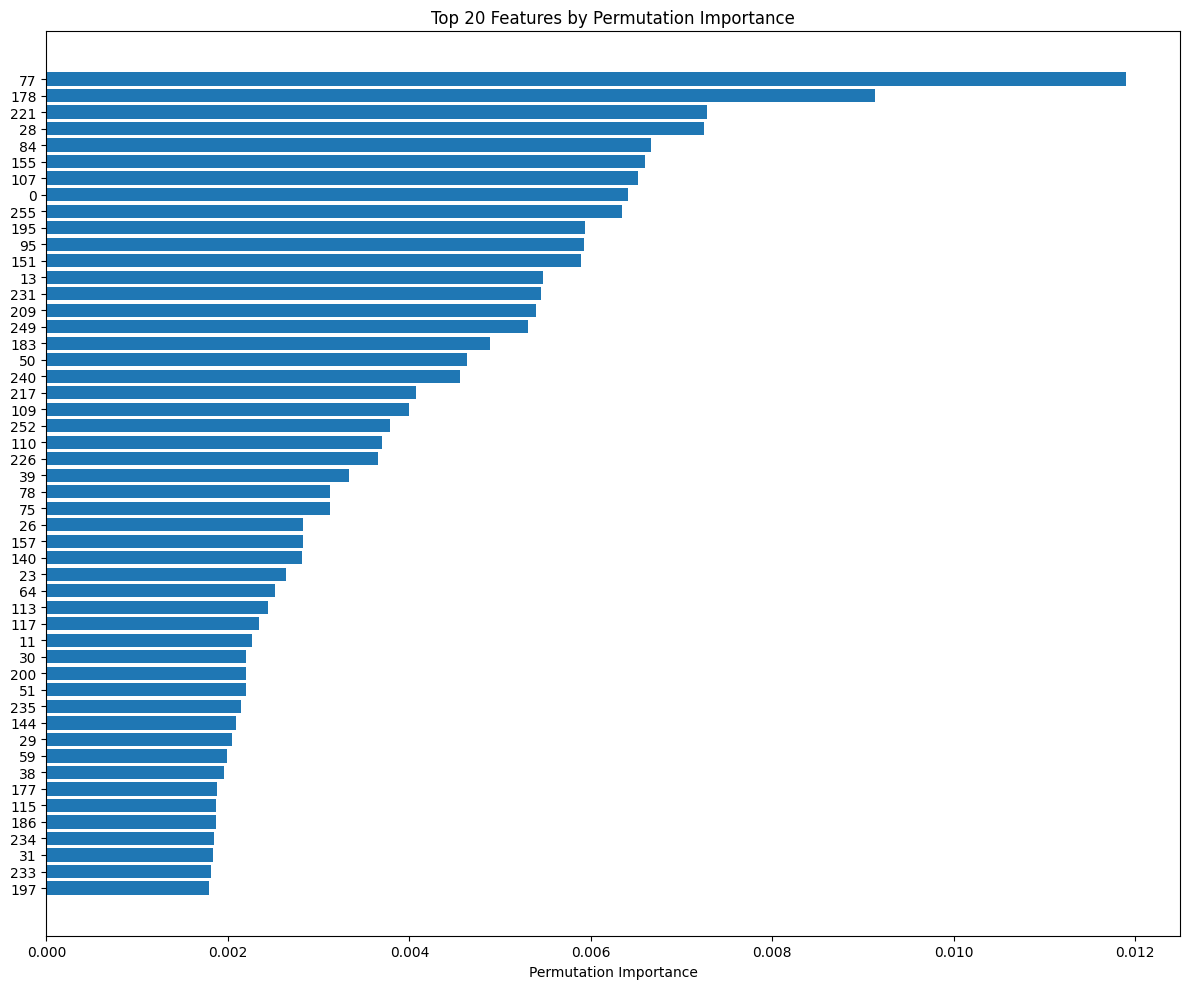

In [159]:
top_indices = np.argsort(perm_importance.importances_mean)[-50:]
top_importances = perm_importance.importances_mean[top_indices]
top_feature_names = X_test_new.columns[top_indices]
plt.figure(figsize=(12, 10))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Permutation Importance')
plt.title('Top 20 Features by Permutation Importance')
plt.tight_layout()
plt.show()

66


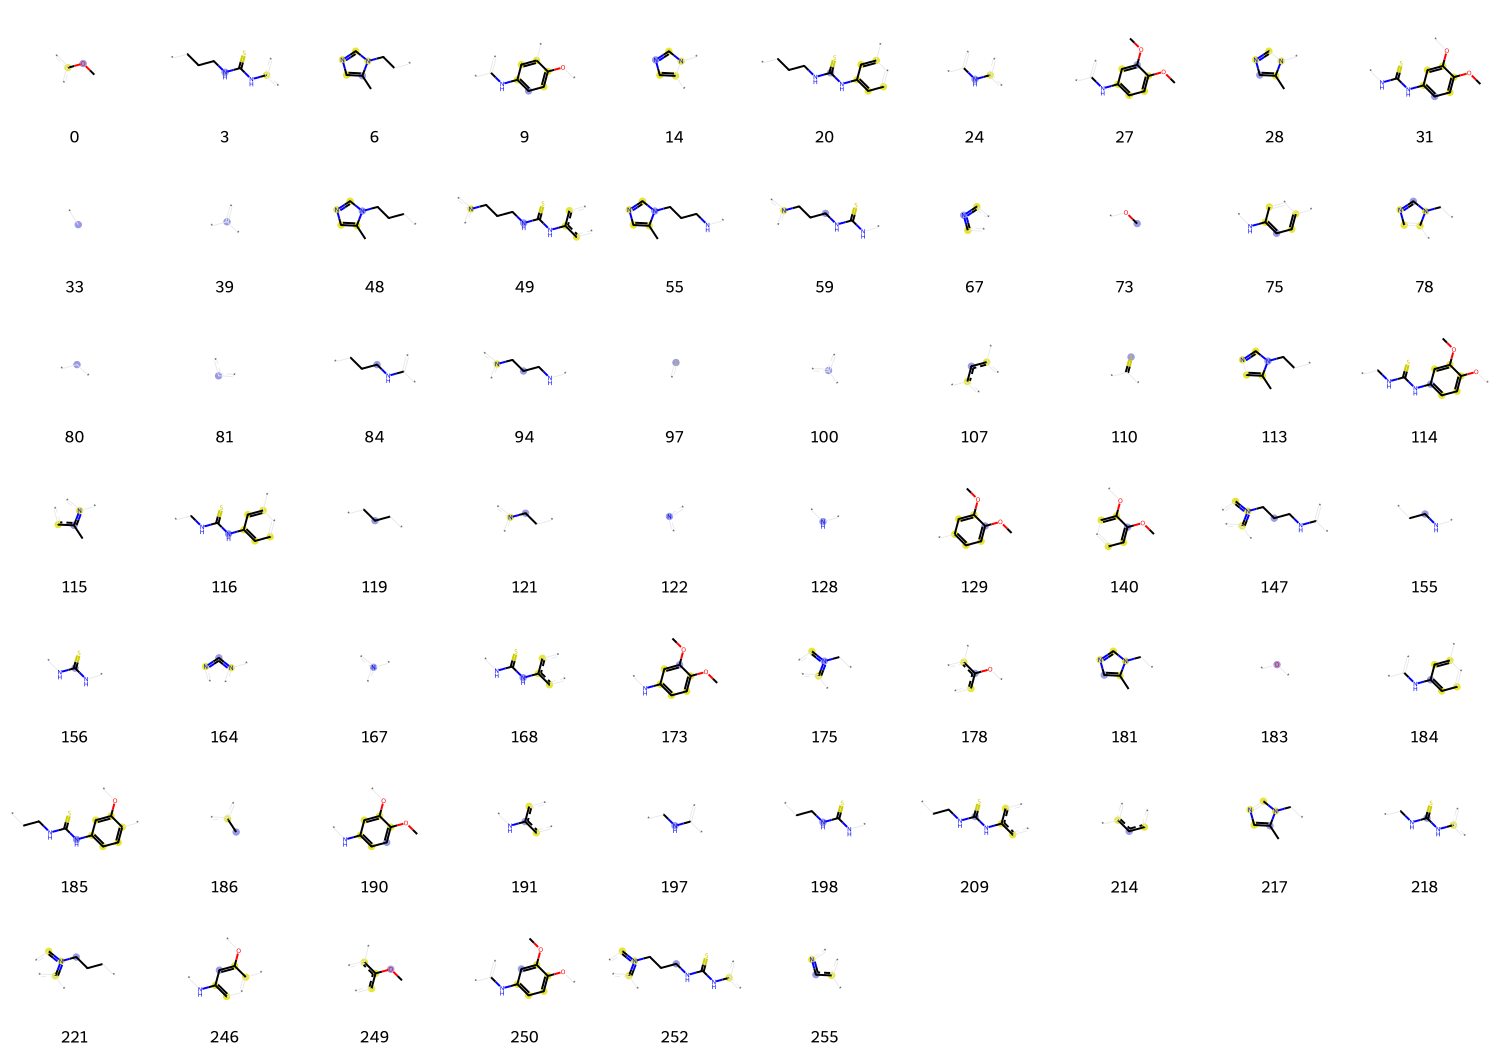

In [161]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

mol = Chem.MolFromSmiles('S=C(NCCCN1C(C)=CN=C1)NC2=CC=C(OC)C(OC)=C2')

bi1 = {}
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4, nBits = 256, bitInfo=bi1)

print(len(list(fp1.GetOnBits())))

tpls1 = [(mol, x, bi1) for x in fp1.GetOnBits()]
Draw.DrawMorganBits(tpls1[:], molsPerRow=10, legends=[str(x) for x in fp1.GetOnBits()][:])